In [ ]:
"""
Simulation of two groups (control vs. "OCD-like") using a dynamic-criterion SDT model.

Model:
    y_t ~ Bernoulli( f( w^T u_t + x_t ) )

where:
    - u_t : input vector on trial t
    - w   : weights on the inputs
    - x_t : latent decision criterion, modeled as an AR(1) process
    - f   : logistic link function (sigmoid)

Design:
    - The underlying (true) sensitivity d' is identical in both groups.
    - The OCD-like group has larger criterion fluctuations:
        * higher standard deviation of the AR(1) noise term ε
        * autoregressive parameter a closer to 1
    - After simulating responses, we fit a classical SDT model with a static criterion and examine observed d' and confidence for each subject.
"""


In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


### Classical SDT: compute d' and criterion c from hits and false alarms

In [ ]:
def compute_dprime(stim, resp):
    """
    Compute d' and decision criterion c from a yes/no SDT task.

    Parameters
    ----------
    stim : array-like of int
        Stimulus labels per trial.
        0 = noise, 1 = signal.
    resp : array-like of int
        Binary responses per trial.
        0 = "no", 1 = "yes".

    Returns
    -------
    d_prime : float
        Sensitivity index d'.
    c : float
        Decision criterion.
    """
    stim = np.asarray(stim)
    resp = np.asarray(resp)

    # Hit rate: P("yes" | signal)
    hit_rate = np.mean(resp[stim == 1] == 1)
    # False alarm rate: P("yes" | noise)
    fa_rate = np.mean(resp[stim == 0] == 1)

    # Avoid 0 or 1 (would send z to ±∞)
    # Had to ask AI
    eps = 1e-4
    hit_rate = np.clip(hit_rate, eps, 1-eps)
    fa_rate = np.clip(fa_rate, eps, 1-eps)

    zH = norm.ppf(hit_rate)
    zF = norm.ppf(fa_rate)

    d_prime = zH - zF
    c = -.5 * (zH + zF)

    return d_prime, c


### Logistic link function

In [ ]:
def logistic(z):
    return 1.0/(1.0 + np.exp(-z))

### Simulate a single subject: $y_t$ ~ Bernoulli( f( $w^T$ $u_t$ + $x_t$ ) )

In [ ]:
def simulate_subject(
        n_trials = 1000,
        n_inputs = 3,
        a = .9,
        sigma_eps = .3,
        b = 0,
        w = None,
        p_signal = .5,
        d_true = 1.5, 
        seed = None
):
    """
    Simulate one subject under a dynamic-criterion SDT model.

    Latent process:
        x_t = b + a * x_{t-1} + eps_t          (AR(1) decision criterion)
        z_t = w^T u_t + x_t                    (linear predictor)
        p_t = logistic(z_t)
        y_t ~ Bernoulli(p_t)

    Inputs:
        - We keep a 0/1 stimulus code for SDT analyses (stim: 0 = noise, 1 = signal).
        - For the decision variable, we use a signed stimulus code: stim_signed = -1 (noise), +1 (signal),
          so that the two internal evidence distributions are symmetric around 0.

    Parameters
    ----------
    n_trials : int
        Number of trials to simulate.
    n_inputs : int
        Dimensionality of input vector u_t.
    a : float
        AR(1) autoregressive coefficient for the criterion x_t.
    sigma_eps : float
        Standard deviation of the AR(1) noise term ε_t.
    b : float
        Intercept of the AR(1) process.
    w : array-like or None
        Weight vector for the inputs. If None, only the first input (stimulus)
        is used with weight d_true; all other inputs are set to 0.
    p_signal : float
        Probability of a signal trial (P(stim=1)).
    d_true : float
        "True" underlying sensitivity parameter (used as weight on the stimulus input).
    seed : int or None
        Random seed for reproducibility.

    Returns
    -------
    result : dict
        Dictionary containing:
        - "y"      : responses (0/1)
        - "p"      : response probabilities
        - "x"      : latent criterion time series
        - "u"      : input matrix
        - "w"      : weight vector
        - "stim"   : 0/1 stimulus labels (for SDT)
        - "conf"   : confidence per trial, defined as |dv - x|
    """

    rng = np.random.default_rng(seed)

    # Stimulus for SDT: 0 = noise, 1 = signal
    stim = rng.binomial(1, p_signal, size = n_trials)

    # Signed stimulus for the decision variable: -1 (noise), +1 (signal)
    stim_signed = 2 * stim - 1 # 0 -> -1 and 1 -> +1

    # Weights w
    if w is None:
        w = np.zeros(n_inputs)
        # The first input is the (signed) stimulus, with weight equal to d_true
        w[0] = d_true

    # Inputs u: first column = signed stimulus, remaining columns = mean-centered noise covariates
    u = np.zeros((n_trials, n_inputs))
    u[:, 0] = stim_signed

    if n_inputs > 1:
        other = rng.normal(loc = 0.0, scale = 1.0, size = (n_trials, n_inputs-1))
        other -= other.mean(axis = 0, keepdims = True) # mean-center each column
        u[:, 1:] = other

    # Latent criterion x_t (AR(1) process)
    x = np.zeros(n_trials) 
    x[0] = 0.0
    for t in range(1, n_trials):
        eps_t = rng.normal(loc = 0.0, scale = sigma_eps)
        x[t] = b + a * x[t-1] + eps_t

    # Linear predictor and response probabilities
    dv = u @ w #decision variable
    linpred = dv + x
    p = logistic(linpred)

    # Binary responses y_t ~ Bernoulli(p_t)
    y = rng.binomial(1, p, size = n_trials)

    # Confidence: distance between decision variable and current criterion
    conf = np.abs(dv - x)

    return {
        "y" : y,
        "p" : p,
        "x" : x,
        "u" : u,
        "w" : w,
        "stim" : stim,  # keep 0/1 code for classical SDT
        "conf" : conf   # |dv - x|
    }


### Simulate a group of subjects (control or OCD-like)

In [ ]:
def simulate_group(
    n_subj = 30,
    n_trials = 1000,
    n_inputs = 3,
    a = .9,
    sigma_eps = .3,
    b = 0.0,
    d_true = 1.5,
    seed = 0
):
    
    """
    Simulate a group of subjects with shared AR(1) parameters, but different random seeds.

    Parameters
    ----------
    n_subj : int
        Number of subjects.
    n_trials : int
        Number of trials per subject.
    n_inputs : int
        Dimensionality of input vector u_t.
    a : float
        AR(1) autoregressive coefficient for the criterion x_t.
    sigma_eps : float
        Standard deviation of the AR(1) noise term ε_t.
    b : float
        Intercept of the AR(1) process.
    d_true : float
        "True" underlying sensitivity (weight on stimulus input).
    seed : int or None
        Seed for the group-level RNG that generates subject-level seeds.

    Returns
    -------
    subjects : list of dict
        Each element is the dictionary returned by `simulate_subject`
    """
    rng = np.random.default_rng(seed)
    subjects = []

    for i in range(n_subj):
        subj_seed = rng.integers(1e9) #zorgt voor willekeur
        sim = simulate_subject(
            n_trials= n_trials,
            n_inputs= n_inputs,
            a = a,
            sigma_eps= sigma_eps,
            b= b,
            w = None,
            p_signal= .5,
            d_true = d_true,
            seed = subj_seed
        )
        subjects.append(sim)
    return subjects

### Main analysis: simulate both groups, compute SDT measures, and plot results

--- Observed d' per group (classical SDT fit) ---
Control: mean d' = 1.810, SD = 0.085
OCD:     mean d' = 1.443, SD = 0.099
--- Mean confidence per group ---
Control: mean conf = 1.499, SD = 0.005
OCD:     mean conf = 1.642, SD = 0.052
--- Observed c per group ---
control: mean c = -0.003
OCD:      mean c = -0.007
d': t = 19.748, p = 1.593e-35
Confidence: t = -19.024, p = 1.688e-24


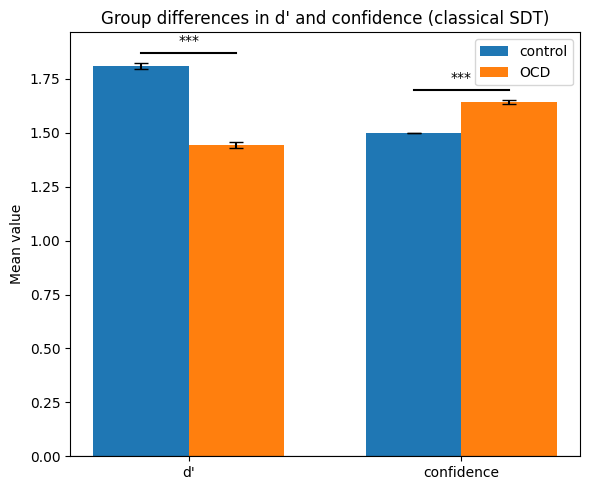

In [12]:
def main():
    # -----------------------------
    # Simulation parameters
    # -----------------------------
    n_subj = 50
    n_trials = 1000
    n_inputs = 3
    d_true = 1.5

    # Control group: smaller criterion fluctuations
    a_control = .5
    sigma_control = .15

    # OCD-like group: larger criterion fluctuations
    a_OCD = .95
    sigma_OCD = .40

    # -----------------------------
    # Simulate both groups
    # -----------------------------
    control_subjects = simulate_group(
        n_subj= n_subj,
        n_trials= n_trials,
        n_inputs= n_inputs,
        a = a_control,
        sigma_eps= sigma_control,
        b = 0,
        d_true= d_true,
        seed = None
    )

    OCD_subjects = simulate_group(
        n_subj= n_subj,
        n_trials= n_trials,
        n_inputs= n_inputs,
        a = a_OCD,
        sigma_eps= sigma_OCD,
        b = 0,
        d_true= d_true,
        seed = None
    )

    # -----------------------------
    # Compute d' and mean confidence per subject
    # -----------------------------

    d_control = []
    d_OCD = []
    conf_mean_control = []
    conf_mean_OCD = []
   

    for subj in control_subjects:
        stim = subj["stim"]
        resp = subj["y"]
        d_prime, c = compute_dprime(stim, resp)
        d_control.append(d_prime)
        conf_mean_control.append(subj["conf"].mean())

    for subj in OCD_subjects:
        stim = subj["stim"]
        resp = subj["y"]
        d_prime, c = compute_dprime(stim, resp)
        d_OCD.append(d_prime)
        conf_mean_OCD.append(subj["conf"].mean())

    d_control = np.array(d_control)
    d_OCD = np.array(d_OCD)
    conf_mean_control = np.array(conf_mean_control)
    conf_mean_OCD      = np.array(conf_mean_OCD)

    print("--- Observed d' per group (classical SDT fit) ---")
    print(f"Control: mean d' = {d_control.mean():.3f}, SD = {d_control.std():.3f}")
    print(f"OCD:     mean d' = {d_OCD.mean():.3f}, SD = {d_OCD.std():.3f}")

    print("--- Mean confidence per group ---")
    print(
        f"Control: mean conf = {conf_mean_control.mean():.3f}, "
        f"SD = {conf_mean_control.std():.3f}"
    )
    print(
        f"OCD:     mean conf = {conf_mean_OCD.mean():.3f}, "
        f"SD = {conf_mean_OCD.std():.3f}"
    )

    # -----------------------------
    # Compute observed c per group
    # -----------------------------

    c_control = []
    c_OCD = []

    for subj in control_subjects:
        d_prime, c = compute_dprime(subj["stim"], subj["y"])
        c_control.append(c)

    for subj in OCD_subjects:
        d_prime, c = compute_dprime(subj["stim"], subj["y"])
        c_OCD.append(c)

    c_control = np.array(c_control)
    c_ocd = np.array(c_OCD)

    print("--- Observed c per group ---")
    print(f"control: mean c = {np.mean(c_control):.3f}")
    print(f"OCD:      mean c = {np.mean(c_OCD):.3f}")

    # -----------------------------
    # Group-level t-tests (AI was used to figure this out)
    # -----------------------------

    tval_dprime, pval_dprime = ttest_ind(d_control, d_OCD, equal_var=False)
    tval_conf, pval_conf = ttest_ind(conf_mean_control, conf_mean_OCD, equal_var=False)

    print(f"d': t = {tval_dprime:.3f}, p = {pval_dprime:.3e}")
    print(f"Confidence: t = {tval_conf:.3f}, p = {pval_conf:.3e}")

    # -----------------------------
    # Bar plot: d' and confidence by group (I had some help from AI here to figure out how to shape this nicely)
    # -----------------------------
    mean_d_control = d_control.mean()
    mean_d_OCD  = d_OCD.mean()
    mean_conf_control = conf_mean_control.mean()
    mean_conf_OCD = conf_mean_OCD.mean()

    se_d_control = d_control.std(ddof=1) / np.sqrt(len(d_control))
    se_d_OCD  = d_OCD.std(ddof=1) / np.sqrt(len(d_OCD))
    se_conf_control = conf_mean_control.std(ddof=1) / np.sqrt(len(conf_mean_control))
    se_conf_OCD = conf_mean_OCD.std(ddof=1) / np.sqrt(len(conf_mean_OCD))

    #data in arrays
    means_control = np.array([mean_d_control, mean_conf_control])
    means_OCD = np.array([mean_d_OCD, mean_conf_OCD])
    ses_control = np.array([se_d_control, se_conf_control])
    ses_OCD = np.array([se_d_OCD, se_conf_OCD])

    labels = ["d'", "confidence"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 5))

    ax.bar(x - width/2, means_control, width,
        yerr=ses_control, capsize=5, label="control")
    ax.bar(x + width/2, means_OCD,  width,
        yerr=ses_OCD,  capsize=5, label="OCD")

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Mean value")
    ax.set_title("Group differences in d' and confidence (classical SDT)")
    ax.axhline(0, color="black", linewidth=0.8)
    ax.legend()

    # Significance stars helper
    def p_to_stars(p):
        if p < 0.001:
            return "***"
        elif p < 0.01:
            return "**"
        elif p < 0.05:
            return "*"
        else:
            return "n.s."

    # Significance line for d'
    y_max_d = max(means_control[0] + ses_control[0],
                  means_OCD[0]  + ses_OCD[0])
    y_sig_d = y_max_d + 0.05
    ax.plot([x[0] - width/2, x[0] + width/2],
            [y_sig_d, y_sig_d], color="black")
    ax.text(x[0], y_sig_d + 0.02, p_to_stars(pval_dprime),
            ha="center", va="bottom")

    # Significance line for confidence
    y_max_c = max(means_control[1] + ses_control[1],
                  means_OCD[1]  + ses_OCD[1])
    y_sig_c = y_max_c + 0.05
    ax.plot([x[1] - width/2, x[1] + width/2],
            [y_sig_c, y_sig_c], color="black")
    ax.text(x[1], y_sig_c + 0.02, p_to_stars(pval_conf),
            ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()